In [1]:
#IMPORTS
#built-in
import argparse
import ast
import os
import pickle

#third party
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from google.cloud import storage, bigquery
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import WeightedRandomSampler

#local
from dataloader_mayo import AudioDataset
from dataloader_mayo import collate_fn
from utilities import ClassificationHead

import timm

In [2]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
#data loading
parser.add_argument('-i','--prefix',default='speech_ai/speech_lake/speech_poc_freeze_1', help='Input directory or location in google cloud storage bucket containing files to load')
parser.add_argument('-d','--data_split_root', default='gs://ml-e107-phi-shared-aif-us-p/speech_ai/share/data_splits/amr_subject_dedup_594_train_100_test_binarized_v20220620', help='path to datasplit csvs. Assumes it points to a directory with a train.csv and test.csv')
#GCS
parser.add_argument('-b','--bucket_name', default='ml-e107-phi-shared-aif-us-p', help="google cloud storage bucket name")
parser.add_argument('-p','--project_name', default='ml-mps-aif-afdgpet01-p-6827', help='google cloud platform project name')
#librosa vs torchaudio
parser.add_argument('--lib', default=True, type=bool, help="Specify whether to load using librosa as compared to torch audio")
#output
parser.add_argument('-o',"--exp_dir", type=str, default="/Users/m144443/Documents/mayo_ssast/experiments", help="directory to dump experiments")
#Audio configuration parameters
parser.add_argument("--dataset", default='mayo',type=str, help="the dataset used for training")
parser.add_argument("--dataset_mean", default=-4.2677393, type=float, help="the dataset mean, used for input normalization")
parser.add_argument("--dataset_std", default=4.5689974, type=float, help="the dataset std, used for input normalization")
parser.add_argument("--target_length", default=1024, type=int, help="the input length in frames")
parser.add_argument("--num_mel_bins", default=128,type=int, help="number of input mel bins")
parser.add_argument("--resample_rate", default=16000,type=int, help='resample rate for audio files')
parser.add_argument("--reduce", default=True, type=bool, help="Specify whether to reduce to monochannel")
parser.add_argument("--clip_length", default=0, type=int, help="If truncating audio, specify clip length in # of frames. 0 = no truncation")
parser.add_argument("--tshift", default=0, type=float, help="Specify p for time shift transformation")
parser.add_argument("--speed", default=0, type=float, help="Specify p for speed tuning")
parser.add_argument("--gauss", default=0, type=float, help="Specify p for adding gaussian noise")
parser.add_argument("--pshift", default=0, type=float, help="Specify p for pitch shifting")
parser.add_argument("--pshiftn", default=0, type=float, help="Specify number of steps for pitch shifting")
parser.add_argument("--gain", default=0, type=float, help="Specify p for gain")
parser.add_argument("--stretch", default=0, type=float, help="Specify p for audio stretching")
parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--noise", type=bool, default=False, help="specify if augment noise in finetuning")
parser.add_argument("--skip_norm", type=bool, default=False, help="specify whether to skip normalization on spectrogram")
#Model parameters
parser.add_argument("--task", type=str, default='ft_cls', help="pretraining or fine-tuning task", choices=["ft_avgtok", "ft_cls", "pretrain_mpc", "pretrain_mpg", "pretrain_joint"])
parser.add_argument("--fstride", type=int, default=128,help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, default=2, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument("--fshape", type=int, default=128,help="shape of patch on the frequency dimension")
parser.add_argument("--tshape", type=int, default=2, help="shape of patch on the time dimension")
parser.add_argument('--model_size', default='base',help='the size of AST models', type=str)
#Training parameters
parser.add_argument('--batch_size', default=8, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--num_workers', default=0, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--epochs", type=int, default=1, help="number of maximum training epochs")
parser.add_argument("--loss", type=str, default="BCE", help="the loss function for finetuning, depend on the task", choices=["BCE", "CE"])
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["adamw", "adam"])
parser.add_argument('--lr', '--learning-rate', default=0.001, type=float, metavar='LR', help='initial learning rate')
parser.add_argument('--warmup', help='if use warmup learning rate scheduler', type=ast.literal_eval, default='True')
parser.add_argument("--lr_patience", type=int, default=1, help="how many epoch to wait to reduce lr if mAP doesn't improve")
parser.add_argument('--adaptschedule', help='if use adaptive scheduler ', type=ast.literal_eval, default='False')
parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")
parser.add_argument('--save_model', help='save the models or not', type=ast.literal_eval, default='True')
#fine-tuning parameters
parser.add_argument("--pretrained_mdl_path", type=str, help="the ssl pretrained models path", default='/home/jupyter/mayo_ssast/mayo-ssast-old/src/trained/SSAST-Base-Frame-400.pth') #/Users/m144443/Documents/mayo_ssast/pretrained_model/SSAST-Base-Frame-400.pth
parser.add_argument("--freeze",type=bool, default=True, help="Specify whether to freeze original model before fine-tuning")
parser.add_argument("--basic", type=bool, default=True, help="run basic finetuning/metrics rather than altering lr or anything else")
parser.add_argument("--head_lr", type=int, default=1, help="the factor of mlp-head_lr/lr, used in some fine-tuning experiments only")
parser.add_argument("--metrics", type=str, default="mAP", help="the main evaluation metrics for validation in finetuning", choices=["mAP", "acc"])
parser.add_argument("--lrscheduler_start", default=10, type=int, help="when to start decay in finetuning")
parser.add_argument("--lrscheduler_step", default=5, type=int, help="the number of step to decrease the learning rate in finetuning")
parser.add_argument("--lrscheduler_decay", default=0.5, type=float, help="the learning rate decay ratio in finetuning")
parser.add_argument("--wa", help='if do weight averaging in finetuning', type=ast.literal_eval, default='False')
parser.add_argument("--wa_start", type=int, default=16, help="which epoch to start weight averaging in finetuning")
parser.add_argument("--wa_end", type=int, default=30, help="which epoch to end weight averaging in finetuning")
#pretraining parameters
parser.add_argument('--mask_patch', help='how many patches to mask (used only for ssl pretraining)', type=int, default=400)
parser.add_argument("--cluster_factor", type=int, default=3, help="mask clutering factor")
parser.add_argument("--epoch_iter", type=int, default=2000, help="for pretraining, how many iterations to verify and save models")
#evaluation
parser.add_argument('--eval_only', type=bool, default=False, help="specify if you want to only run evaluation - use pretrained_mdl_path to specify which model to load for evaluation")
parser.add_argument("--mdl_path", type=str, default='/Users/m144443/Documents/mayo_ssast/experiments/models/audio_model.1.pth', help="if loading an already pre-trained/fine-tuned model")
args, unknown = parser.parse_known_args()

## Setting up environment
The first step is to make sure the GCS bucket is initialized if given a `bucket_name`. Additionally, the list of target labels must be set. 

In the original implementation, the list must be given as a `.txt` file to pass through the command line. In this implementation, we will set it as a list.

In [3]:
# GCS set up
if args.bucket_name is not None:
    storage_client = storage.Client(project=args.project_name)
    bq_client = bigquery.Client(project=args.project_name)
    bucket = storage_client.bucket(args.bucket_name)
else:
    bucket = None

In [4]:
#target labels
target_labels=['slow rate']
#set number of target classes for classification
args.n_class = len(target_labels)

## Loading data
The data must be loaded in steps, starting by loading in the label data, then setting up audio configurations for training and evaluation, then generating AudioDataset objects, and finally setting up the dataloaders.

When loading data, we start with a data split root, which we expect to be a directory containing a `train.csv` file and `test.csv` file with file names for train/test and the associated label data.

The audio configurations are dictionaries with parameters for altering the audio and generating spectrograms.

The AudioDatasets are set up in the `dataloader_mayo.py` script, using transforms specified in `utilities/dataloader_utils.py`. 

Finally, the dataloaders take in the datasets and batch size + number of workers.

Please note that the resulting samples will be a dictionary with the keys `uid`, `fbank`, `waveform`, `targets`, `sample_rate`.

In [5]:
def load_data(data_split_root):
    '''
    This function assumes data loading based on previous notebooks - if anything changes with the 
    CSVs or columns need to be altered differently, this is the function to change
    '''
    #Note: assumes that the data split root is a path to a folder containing a train.csv and test.csv 
    train_path = f'{data_split_root}/train.csv'
    test_path = f'{data_split_root}/test.csv'
    
    # (1) load the train and test files to a df (requires a 'uid' column)
    train_df = pd.read_csv(train_path, index_col = 'uid')
    test_df = pd.read_csv(test_path, index_col = 'uid')

    #(2) alter data columns
    train_df["distortions"]=((train_df["distorted Cs"]+train_df["distorted V"])>0).astype(int)
    test_df["distortions"]=((test_df["distorted Cs"]+test_df["distorted V"])>0).astype(int)

    return train_df, test_df

In [6]:
#(1) Load data, note that we are not doing any validation
train_df, test_df = load_data(args.data_split_root)

#(2) set audio configurations (again, no val_loader because no validation set)
train_audio_conf = {'dataset': args.dataset, 'mode': 'train', 'resample_rate': args.resample_rate, 'reduce': args.reduce, 'clip_length': args.clip_length,
                'tshift':args.tshift, 'speed':args.speed, 'gauss_noise':args.gauss, 'pshift':args.pshift, 'pshiftn':args.pshiftn, 'gain':args.gain, 'stretch': args.stretch,
                'num_mel_bins': args.num_mel_bins, 'target_length': args.target_length, 'freqm': args.freqm, 'timem': args.timem, 'mixup': args.mixup, 'noise':args.noise,
                'mean':args.dataset_mean, 'std':args.dataset_std, 'skip_norm':args.skip_norm}

eval_audio_conf = {'dataset': args.dataset, 'mode': 'evaluation', 'resample_rate': args.resample_rate, 'reduce': args.reduce, 'clip_length': args.clip_length,
                'tshift':args.tshift, 'speed':args.speed, 'gauss_noise':args.gauss, 'pshift':args.pshift, 'pshiftn':args.pshiftn, 'gain':args.gain, 'stretch': args.stretch,
                'num_mel_bins': args.num_mel_bins, 'target_length': args.target_length, 'freqm': args.freqm, 'timem': args.timem, 'mixup': args.mixup, 'noise':args.noise,
                'mean':args.dataset_mean, 'std':args.dataset_std, 'skip_norm':args.skip_norm}

#(3) Generate audio dataset, note that if bucket not given, it assumes None and loads from local files
train_dataset = AudioDataset(annotations_df=train_df, target_labels=target_labels, audio_conf=train_audio_conf, 
                                prefix=args.prefix, bucket=bucket, librosa=args.lib) #librosa = True (might need to debug this one)
eval_dataset = AudioDataset(annotations_df=test_df, target_labels=target_labels, audio_conf=eval_audio_conf, 
                            prefix=args.prefix, bucket=bucket, librosa=args.lib)

#(4) set up data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=False, drop_last=True, collate_fn=collate_fn)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True, collate_fn=collate_fn)

print('Now train with {:s} with {:d} training samples, evaluate with {:d} samples'.format(args.dataset, len(train_loader.dataset), len(eval_loader.dataset)))

---------------the train dataloader---------------
now process mayo
now using following mask: 0 freq, 0 time
MIXUP NOT CURRENTLY AVAILABLE
use dataset mean -4.268 and std 4.569 to normalize the input.
number of classes is 1
---------------the evaluation dataloader---------------
now process mayo
now using following mask: 0 freq, 0 time
MIXUP NOT CURRENTLY AVAILABLE
use dataset mean -4.268 and std 4.569 to normalize the input.
number of classes is 1
Now train with mayo with 594 training samples, evaluate with 100 samples


### Spectrograms
We can now visualize a spectrogram

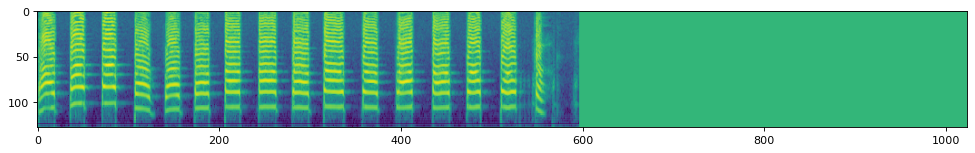

In [7]:
# get a spectrogram
sample = train_loader.dataset[1]
spectrogram = sample['fbank']
label = sample['targets']

from matplotlib import pyplot as plt
plt.figure(num=1, figsize=(15, 15), dpi=80)
plt.imshow(spectrogram.transpose(1,0).flip(0))
plt.show()

In [8]:
spectrogram.shape

torch.Size([1024, 128])

In [9]:
sample['fbank'].shape

torch.Size([1024, 128])

In [10]:
a_batch=next(iter(train_loader))

In [11]:
torch.unsqueeze(a_batch['fbank'],1).shape

torch.Size([8, 1, 1024, 128])

In [12]:
class Model(nn.Module):
    def __init__(self, name,args, *, pretrained=False):
        """
        name (str): timm model name, e.g. tf_efficientnet_b2_ns
        """
        super().__init__()

        # Use timm
        model = timm.create_model(name, pretrained=pretrained, in_chans=1)

        clsf = model.default_cfg['classifier']
        n_features = model._modules[clsf].in_features
        model._modules[clsf] = nn.Identity()

        self.classifier = ClassificationHead(n_features,args.n_class, 'relu', 0.2, False )
        self.model = model

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x    

In [13]:
efficient_net=Model('efficientnet_b0',args, pretrained=False)

In [14]:
efficient_net.cuda()
1

1

In [15]:
# training loop etc

In [16]:
args.epochs=10

In [17]:
args.exp_dir='/home/jupyter/mayo_ssast/timm/experiments'

In [18]:
#RUNNING BASIC FUNCTIONS

def basic_finetune(args, efficient_net, train_loader):
    '''
    Run simple fine-tuning - BCE loss, AdamW optimizer - basic training loop
    '''
    criterion = torch.nn.BCEWithLogitsLoss()
    
    #does not change anything about learning rates and what not
    optim = torch.optim.AdamW([p for p in efficient_net.parameters() if p.requires_grad])

    for e in range(args.epochs):
        running_loss = 0
        for i, batch in enumerate(train_loader):
            x = torch.unsqueeze(batch['fbank'],1).cuda()
            targets = batch['targets'].cuda() #have to change to select targets like this
            optim.zero_grad()
            o =  efficient_net(x) #no need for task + give just fbank
            loss = criterion(o, targets)
            loss.backward()
            optim.step()
            running_loss += loss.item()
            print(f'Progress: {round(i/len(train_loader)*100)}%    ',end='\r')
            
        print(e, running_loss/len(train_loader))

    outname = "_".join(['efficient_net',args.model_size, args.dataset, str(args.n_class), args.optim, str(args.epochs)+'epoch'])+'.pt'
    outpath = os.path.join(args.exp_dir,outname)
    torch.save(efficient_net.state_dict(), outpath)
    return efficient_net

def basic_eval(efficient_net, eval_loader):
    '''
    basic evaluation loop
    '''
    #does not change anything about learning rates and what not
    #optim = torch.optim.AdamW([p for p in efficient_net.parameters() if p.requires_grad])

    efficient_net.eval()
    all_preds=[]
    all_targets=[]
    with torch.no_grad():
        for i, batch in enumerate(eval_loader):
            x = torch.unsqueeze(batch['fbank'],1).cuda()
            targets = batch['targets'].cuda()
            #optim.zero_grad()
            o=efficient_net(x)
            all_preds.append(o)
            all_targets.append(targets)
            print(f'Progress: {round(i/len(eval_loader)*100)}%    ',end='\r')
    
    return all_preds, all_targets    

def basic_metrics(preds, targets, target_labels, args):
    '''
    Get simple metrics: only returns AUC for each label
    '''
    pred_mat=torch.sigmoid(torch.cat(preds)).cpu().detach().numpy()
    target_mat=torch.cat(targets).cpu().detach().numpy()
    aucs=roc_auc_score(target_mat, pred_mat, average = None)
    print(aucs)
    data = [
    ('Label', target_labels),
    ('AUC', target_labels)]
    data = pd.DataFrame({'Label':target_labels, 'AUC':aucs})
    data.to_csv(os.path.join(args.exp_dir, 'basic_metrics.csv'), index=False)
    return (data, pred_mat, target_mat)

In [19]:
#FINE-TUNING LOOPS
if not args.eval_only:
    #(7) Run models
    print('Now starting fine-tuning for {:d} epochs'.format(args.epochs))
    #rather than the entire lr scheduler process, you can choose to run a simple finetuning method + get AUCsjft
    if args.basic:
        efficient_net = basic_finetune(args, efficient_net, train_loader)
    else:
        efficient_net = train(args=args, audio_model=efficient_net, train_loader=train_loader, val_loader=None)

else: #RUN ONLY EVALUATION
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sd = torch.load(args.mdl_path, map_location=device)
    efficient_net.load_state_dict(sd, strict=False)

Now starting fine-tuning for 10 epochs
0 0.6734542153977059
1 0.4900401040307573
2 0.438757103842658
3 0.3827925069207275
4 0.3729462329600308
5 0.3664393605714714
6 0.3410580715013517
7 0.28054888408026984
8 0.2837329359624434
9 0.22384646787887086


In [20]:
preds, targets = basic_eval(efficient_net, eval_loader)
metrics = basic_metrics(preds, targets, target_labels, args)

0.9303542673107891


In [19]:
args.mdl_path='/home/jupyter/mayo_ssast/timm/experiments/efficient_net_base_mayo_1_adam_10epoch.pt'

test loading

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficient_net.to(device)
sd = torch.load(args.mdl_path, map_location=device)
efficient_net.load_state_dict(sd, strict=False)

<All keys matched successfully>

In [21]:
preds, targets = basic_eval(efficient_net, train_loader)
metrics = basic_metrics(preds, targets, target_labels, args)

0.9989010989010989


In [25]:
torch.cuda.empty_cache()